# Baseline

In [1]:
import torch
from PIL import Image
from torchvision.transforms import v2
import torchvision.transforms as v1
from torch import nn
import numpy as np
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load data

**Datasets**

- kidney_1_dense	
    - images
    - labels
- kidney_1_voi  
    - images
    - labels
- kidney_2	
    - images
    - labels
- kidney_3_dense	
    - labels
- kidney_3_sparse
    - images
    - labels

### ¿Do I use one dataset or all of them? ¿How do I merge all the datasets?

I think i can merge the datasets by just merging the images and labels paths. But for now I will just use the `kidney_1_dense` dataset.

### Dataset

In [2]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transform=None, target_transform=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.slices_ids)
    
    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            msk = self.target_transform(msk).squeeze()

        return img, msk

In [3]:
h_resize, w_resize = 224, 224

imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))

transform = v2.Compose([
    v1.ToTensor(),
    v2.Resize(size=(h_resize, w_resize), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
])
target_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(h_resize, w_resize), interpolation=v2.InterpolationMode.NEAREST, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
])

ds = KidneyDataset(imgs_dir=imgs_dir, msks_dir=msks_dir, slices_ids=slices_ids[600:632], transform=transform, target_transform=target_transform)
print("Dataset length:", len(ds))

Dataset length: 32


In [4]:
bs = 32
num_workers = os.cpu_count()
train_dl = DataLoader(ds, batch_size=bs, num_workers=num_workers, shuffle=False, persistent_workers=True)
print("DataLoader length:", len(train_dl))

DataLoader length: 1


## Define model

In [5]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegmentationModel, self).__init__()

        # Define the encoder - a series of convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the decoder - a series of transposed convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:

# Initialize the model with the desired input channels and number of classes
net = SegmentationModel(in_channels=1, num_classes=1)
net.to(device);

## Train model

### Loss function

In [7]:
loss_fn = nn.BCEWithLogitsLoss()

### Optimizer and scheduler

In [8]:
lr = 3e-5
optimizer = torch.optim.Adam(lr=lr, params=net.parameters())

### Metrics

In [9]:
from surface_dice import SurfaceDiceMetric
metric = SurfaceDiceMetric(n_batches=len(train_dl), device=device)

### Train method

In [10]:
def train(epoch):
    train_loss = 0.0
    net.train()
    pbar = tqdm(total=len(ds))
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        logits = net(x).squeeze() 
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.where(logits.detach().sigmoid() >= 0.5, 1, 0)
        train_loss += loss.item()
        pbar.update(len(x))
    pbar.set_description(f"Epoch {epoch} Loss {train_loss:.4f}")
    pbar.close()

    train_loss /= len(train_dl)

    return train_loss

In [11]:
epochs = 200
losses = []

for epoch in range(epochs):
    loss = train(epoch)
    losses.append(loss)

Epoch 199 Loss 0.2975: 100%|██████████| 32/32 [00:00<00:00, 50.37it/s]


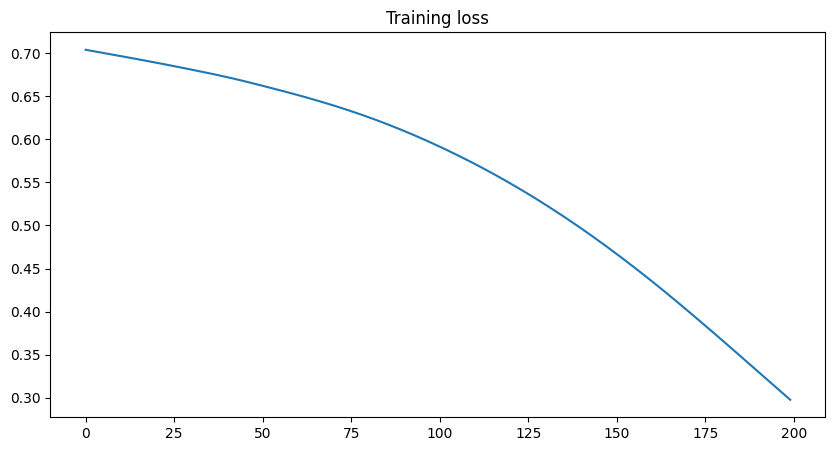

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training loss")
plt.show()

## Inference on train dataset

In [42]:
x, y = next(iter(train_dl))
x = x.cuda()
probs = net(x).squeeze().detach().sigmoid().cpu()
print("loss:", loss_fn(net(x).squeeze().detach().cpu(), y).item())

loss: 0.2939959168434143


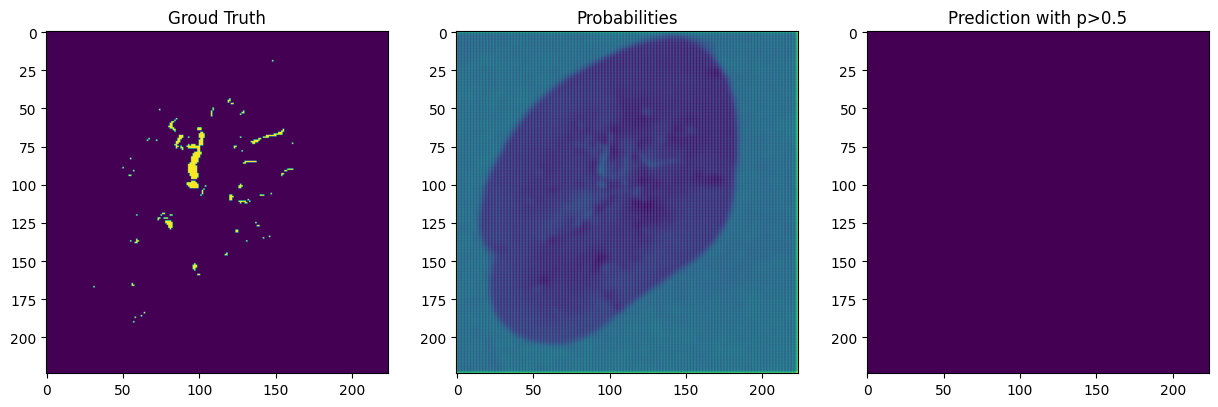

In [49]:
idx = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[2].set_title(f"Prediction with p>{threshold}")
axs[0].set_title("Groud Truth")
axs[1].set_title("Probabilities")
axs[0].imshow(y[idx].numpy())
axs[1].imshow(probs[idx].numpy())
axs[2].imshow(torch.where(probs >= threshold, 1, 0)[idx].numpy())
plt.show()